## Original Strategy

Link: https://www.quantifiedstrategies.com/cci-trading-strategy/

### Original Graph

![Original Graph of CCI Trading Strategy](CCI_Trading_Strategy.png)

### Original Stats

| Metric                          | Value         |
|---------------------------------|---------------|
| Initial Capital                 | 100000.00     |
| Ending Capital                  | 1162814.87    |
| Net Profit                      | 1062814.87    |
| Net Profit %                    | 1062.81%      |
| Exposure %                      | 22.05%        |
| Net Risk Adjusted Return        | 4819.00%      |
| Annual Return %                 | 8.30%         |
| Risk Adjusted Return %          | 37.64%        |
| Transaction Costs               | 0.00          |

| All Trades                      |               |
|---------------------------------|---------------|
| Total Number of Trades          | 464           |
| Avg. Profit/Loss                | 2290.55       |
| Avg. Profit/Loss %              | 0.55%         |
| Avg. Bars Held                  | 4.69          |

| Winners                         |               |
|---------------------------------|---------------|
| Total Profit                    | 2304897.01    |
| Avg. Profit                     | 6700.28       |
| Avg. Profit %                   | 1.40%         |
| Avg. Bars Held                  | 3.72          |
| Max. Consecutive Wins           | 21            |
| Largest Win                     | 46342.60      |
| Bars in Largest Win             | 3             |

| Losers                          |               |
|---------------------------------|---------------|
| Total Loss                      | -1242082.14   |
| Avg. Loss                       | -10350.68     |
| Avg. Loss %                     | -1.67%        |
| Avg. Bars Held                  | 7.46          |
| Max. Consecutive Losses         | 3             |
| Largest Loss                    | -62713.35     |
| Bars in Largest Loss            | 7             |

| Additional Metrics              |               |
|---------------------------------|---------------|
| Max. Trade Drawdown             | -122183.04    |
| Max. Trade % Drawdown           | -23.75%       |
| Max. System Drawdown            | -165830.31    |
| Max. System % Drawdown          | -23.69%       |
| Recovery Factor                 | 6.41          |
| CAR/MaxDD                       | 0.35          |
| RAR/MaxDD                       | 1.59          |
| Profit Factor                   | 1.86          |
| Payoff Ratio                    | 0.65          |
| Standard Error                  | 64937.60      |
| Risk-Reward Ratio               | 0.52          |

## My Recreation of Strategy

### Imports

In [1]:
import sys
from datetime import datetime

new_path = "../"
if new_path not in sys.path:  # Avoid adding duplicates
    sys.path.append(new_path)

import matplotlib.pyplot as plt
import backtrader as bt
import backtrader.analyzers as btanalyzers
import pandas as pd
import numpy as np

from analyzers import InMarketAnalyzer, CashValueAnalyzer, SortinoRatio
from strategies import StrategyBase
from utils import print_strategy_stats


### Strategy Implimentation

In [4]:
class CCIStrategy(StrategyBase):
    params = (
        ("period", 20),  # CCI period for calculation
        ("lowerband", -100),  # Oversold threshold
    )

    def __init__(self):
        # Initialize the CCI indicator
        super().__init__()
        self.cci = bt.indicators.CommodityChannelIndex(
            period=self.params.period
        )
        self.test_long = False
        self.test_close = False

    def long_condition(self):
        if self.cci[0] < self.params.lowerband:
            return True
        else:
            return False

    def close_condition(self):
        if self.data.close[0] > self.data.high[-1]:
            return True
        else:
            return False

    def next(self):
        self.dates.append(self.data.datetime.date(0))
        self.equity_curve.append(self.broker.getvalue())
        # Check if we are in the market
        if not self.cheating:
            if not self.position and self.long_condition():
                self.buy(exectype=bt.Order.Market)
            if self.position and self.close_condition():
                self.close()
        else:
            if not self.position and self.long_condition():
                self.test_long = True
            if self.position and self.close_condition():
                self.test_close = True

    def next_open(self):
        # Check if we are in the market
        if self.test_long:
            # Buy signal: CCI crosses above the oversold threshold
            self.cash = self.broker.getcash()
            next_day_open = self.data.open[0]
            size_to_buy = self.cash / next_day_open
            self.buy(exectype=bt.Order.Market, size=size_to_buy)
            self.test_long = False
        if self.test_close:
            self.close()
            self.test_close = False

### Backtesting

#### COO: False, COC: False

In [5]:
# Create a cerebro engine instance
cerebro = bt.Cerebro(cheat_on_open=False)
start_date = datetime(1993, 1, 29)
end_date = datetime(2024, 7, 12)
data = bt.feeds.YahooFinanceCSVData(dataname='../Data/SPY.csv', fromdate=start_date, todate=end_date, adjclose=True, round=False)
cerebro.adddata(data)

# Add the WilliamsR strategy
cerebro.addstrategy(CCIStrategy, period=9, lowerband=-90.0)
cerebro.broker.setcommission(commission=0.0)
cerebro.broker.set_coc(False)

# Set initial capital and broker settings
# This code was assited using Codeium autocomplete
start_cash = 100000.0000
cerebro.broker.setcash(start_cash)
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name="trade_stats")
cerebro.addanalyzer(btanalyzers.DrawDown, _name="drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name="returns")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, 
                _name='sharpe',
                timeframe=bt.TimeFrame.Days,
                compression=1,
                riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
cerebro.addanalyzer(InMarketAnalyzer, _name="in_market")
cerebro.addanalyzer(CashValueAnalyzer, _name="cash_value")
cerebro.addanalyzer(SortinoRatio, _name='sortino')

# Print starting capital
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run the strategy
strat = cerebro.run()

# Print final capital
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
1993-03-23, Buy Order Margin
1993-04-05, Buy Order Margin
1993-04-06, Buy Order Margin
1993-04-07, Buy Order Margin
1993-04-08, Buy Order Margin
1993-04-23, BUY EXECUTED, 24.672085
1993-04-30, SELL EXECUTED, 24.830355
1993-06-09, Buy Order Margin
1993-06-24, Buy Order Margin
1993-07-07, BUY EXECUTED, 25.041768
1993-07-09, SELL EXECUTED, 25.413658
1993-07-23, Buy Order Margin
1993-09-09, BUY EXECUTED, 25.909529
1993-09-13, SELL EXECUTED, 26.387702
1993-09-21, Buy Order Margin
1993-09-22, Buy Order Margin
1993-09-23, Buy Order Margin
1993-11-05, BUY EXECUTED, 26.070983
1993-11-09, SELL EXECUTED, 26.480837
1993-11-23, Buy Order Margin
1994-02-08, Buy Order Margin
1994-02-25, Buy Order Margin
1994-02-28, Buy Order Margin
1994-03-02, BUY EXECUTED, 26.428864
1994-03-07, SELL EXECUTED, 26.895362
1994-03-25, Buy Order Margin
1994-03-28, Buy Order Margin
1994-03-29, Buy Order Margin
1994-03-30, Buy Order Margin
1994-03-31, Buy Order Margin
1994-04-04, Buy Ord

In [6]:
print(print_strategy_stats(strat[0]))


| Metric                          | Value         |
|---------------------------------|---------------|
| Initial Capital                 | 100000.00     |
| Ending Capital                  | 415049.37      |
| Net Profit                      | 315049.37 |
| Net Profit %                    | 142.32%    |
| Exposure %                      | 10.24%           |
| Net Risk Adjusted Return        | 45.24%      |
| Annual Return %                 | 4.63%   |
| Risk Adjusted Return %          | 45.24%      |
| Transaction Costs               | 0.00                                  |

| All Trades                      |               |
|---------------------------------|---------------|
| Total Number of Trades          | 208            |
| Avg. Profit/Loss                | 1.51                        |
| Avg. Profit/Loss %              | N/A                                   |
| Avg. Bars Held                  | N/A                                   |

| Winners                         |    


| Metric                          | Value         |
|---------------------------------|---------------|
| Initial Capital                 | 100000.00     |
| Ending Capital                  | 415049.37      |
| Net Profit                      | 315049.37 |
| Net Profit %                    | 142.32%    |
| Exposure %                      | 10.24%           |
| Net Risk Adjusted Return        | 45.24%      |
| Annual Return %                 | 4.63%   |
| Risk Adjusted Return %          | 45.24%      |
| Transaction Costs               | 0.00                                  |

| All Trades                      |               |
|---------------------------------|---------------|
| Total Number of Trades          | 208            |
| Avg. Profit/Loss                | 1.51                        |
| Avg. Profit/Loss %              | N/A                                   |
| Avg. Bars Held                  | N/A                                   |

| Winners                         |               |
|---------------------------------|---------------|
| Total Profit                    | 552247.89         |
| Avg. Profit                     | 3586.03     |
| Avg. Profit %                   | N/A                                   |
| Avg. Bars Held                  | N/A                                   |
| Max. Consecutive Wins           | 22      |
| Largest Win                     | N/A                                   |
| Bars in Largest Win             | N/A                                   |

| Losers                          |               |
|---------------------------------|---------------|
| Total Loss                      | -237198.52        |
| Avg. Loss                       | -4392.57    |
| Avg. Loss %                     | N/A                                   |
| Avg. Bars Held                  | N/A                                   |
| Max. Consecutive Losses         | 3     |
| Largest Loss                    | N/A                                   |
| Bars in Largest Loss            | N/A                                   |

| Additional Metrics              |               |
|---------------------------------|---------------|
| Max. Trade Drawdown             | N/A                                   |
| Max. Trade % Drawdown           |                                       |
| Max. System Drawdown            | 54075.88     |
| Max. System % Drawdown          | 23.60% |
| Recovery Factor                 | N/A                                   |
| CAR/MaxDD                       | N/A                                   |
| RAR/MaxDD                       | N/A                                   |
| Profit Factor                   | 2.328209677707005                       |
| Payoff Ratio                    | N/A                                   |
| Standard Error                  | N/A                                   |
| Risk-Reward Ratio               | N/A                                   |



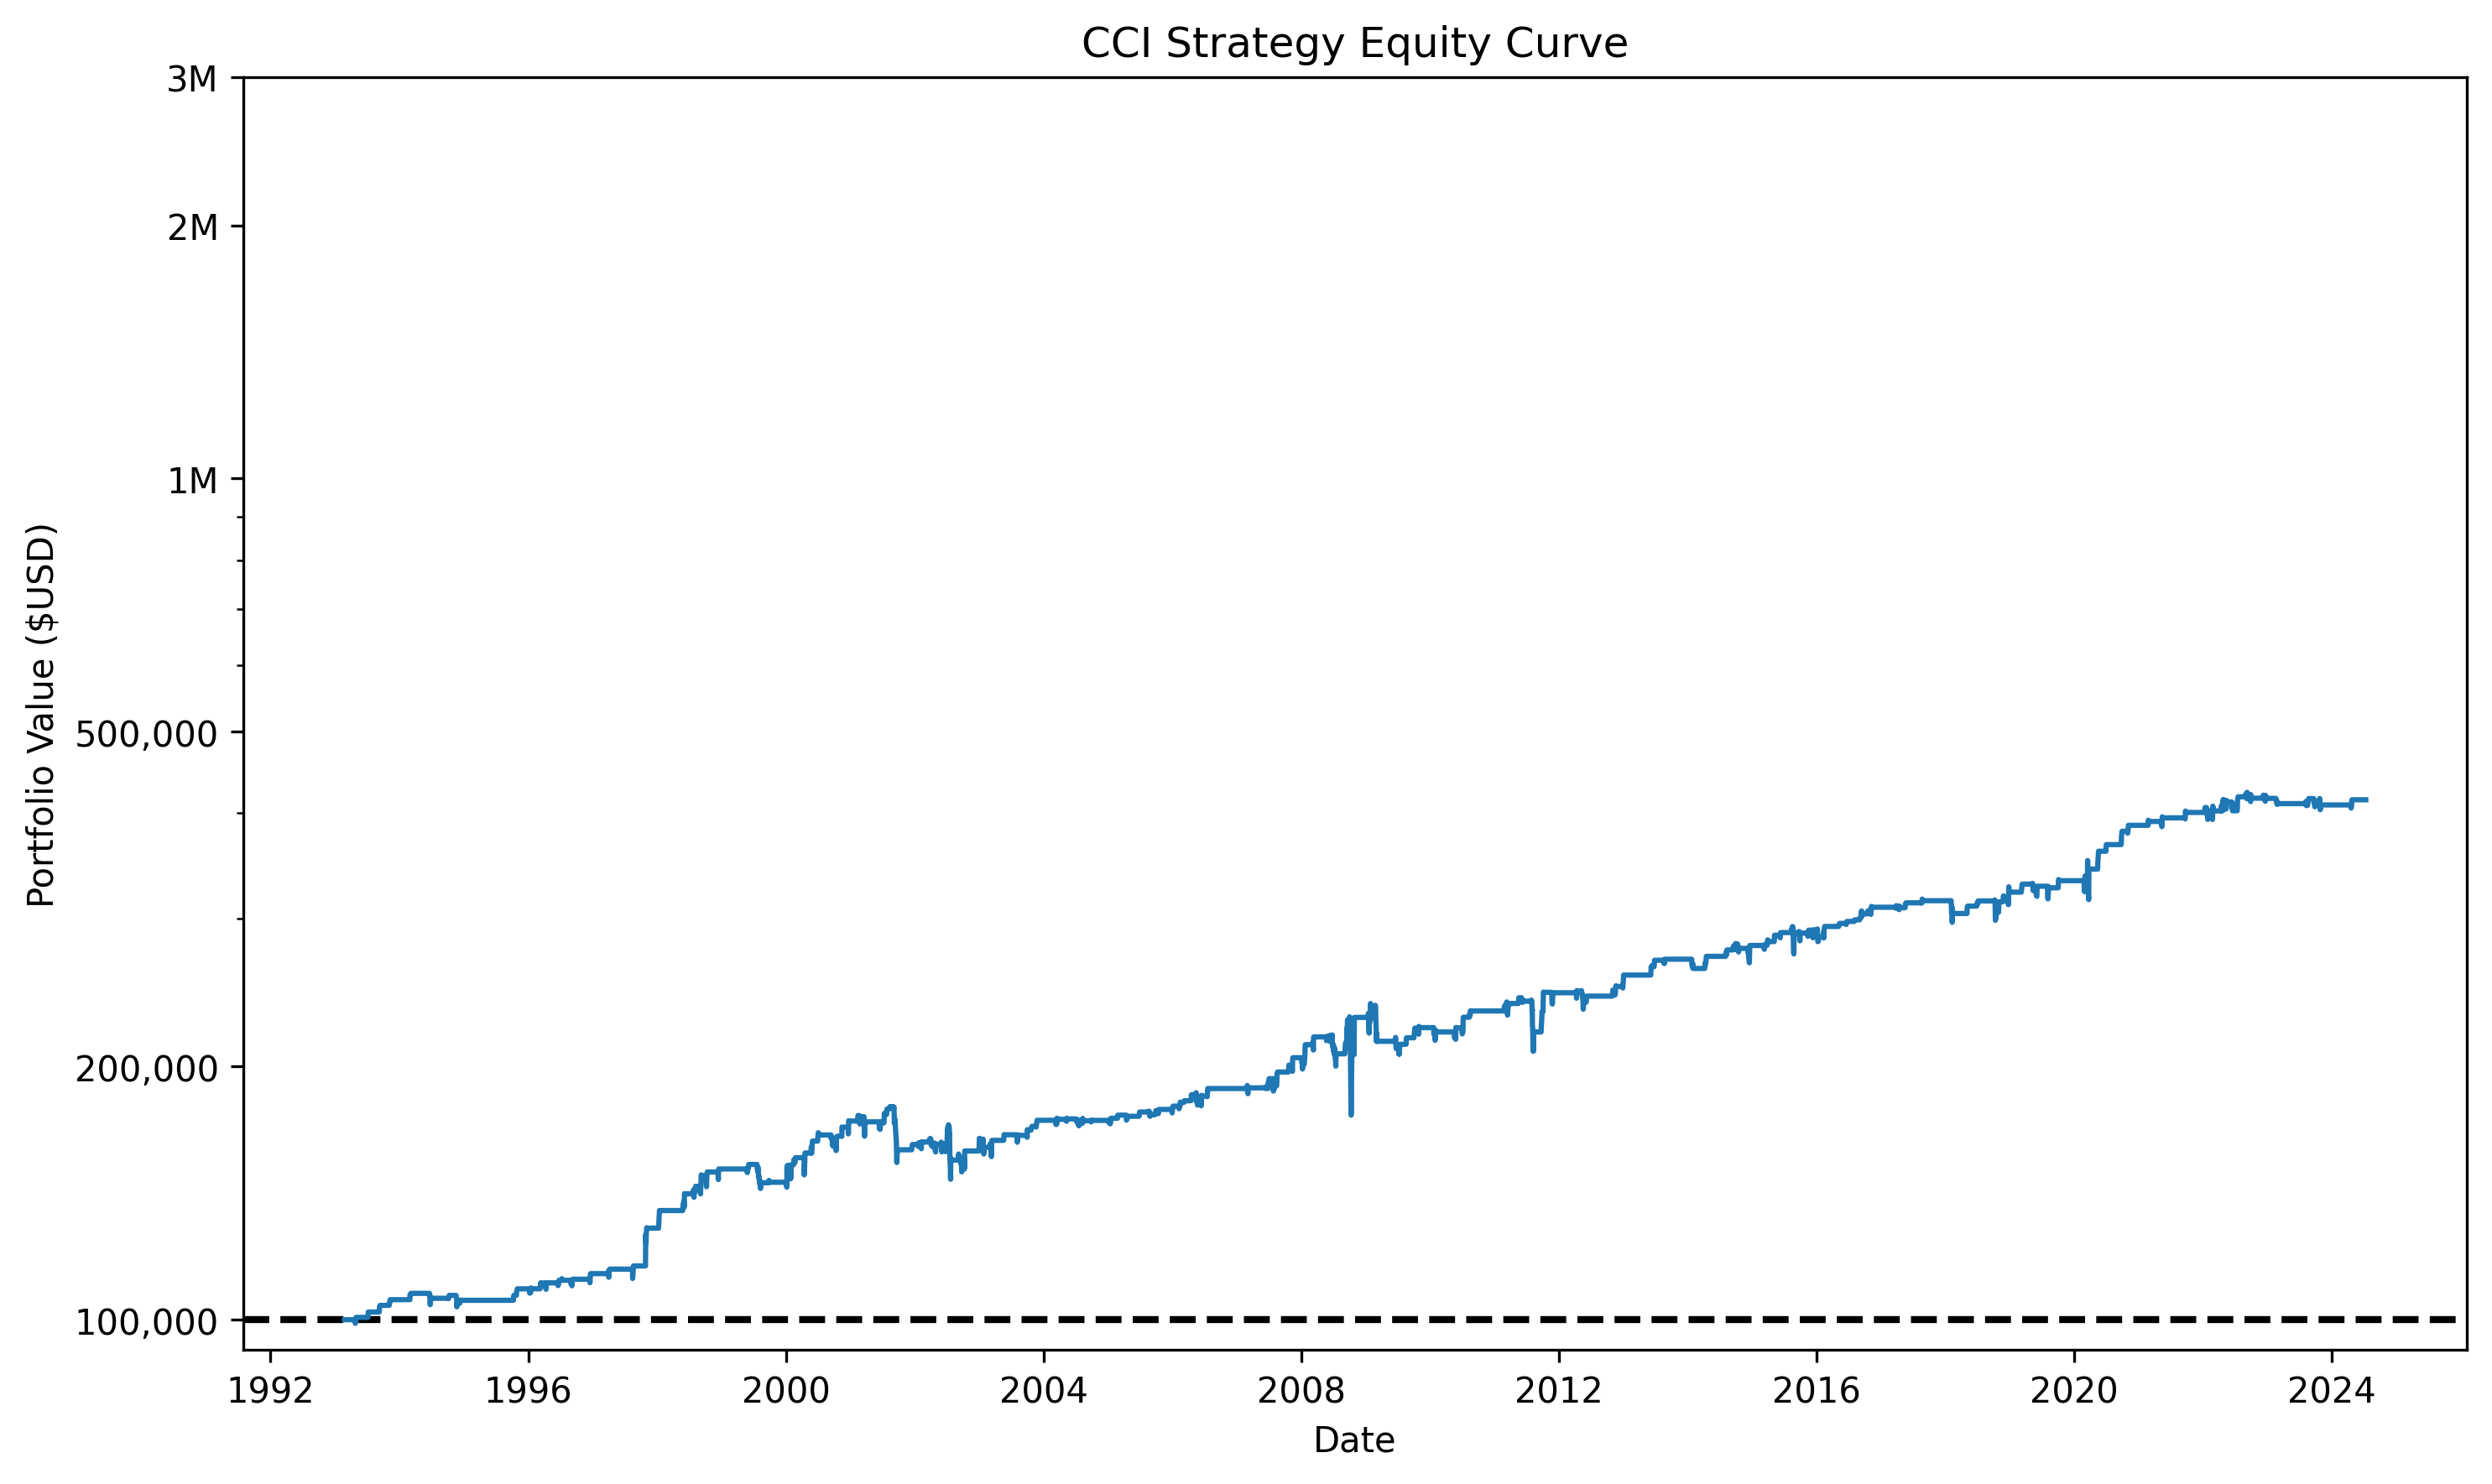

In [7]:
plt.figure(figsize=(10, 6), dpi=300)
plt.axhline(y=100000, color='black', linestyle='--', linewidth=2)

plt.plot(strat[0].dates,strat[0].equity_curve)
plt.title(f"CCI Strategy Equity Curve")
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($USD)')

yticks = [100000, 200000, 500000, 1000000, 2000000, 3000000]
ytick_labels = ['100,000', '200,000', '500,000', '1M', '2M', '3M']

# Set custom y-axis ticks and labels
plt.yscale('log')
plt.yticks(ticks=yticks, labels=ytick_labels)

plt.tight_layout()

#### COO: True

In [8]:
# Create a cerebro engine instance
cerebro = bt.Cerebro(cheat_on_open=True)
start_date = datetime(1993, 1, 29)
end_date = datetime(2024, 7, 12)
data = bt.feeds.YahooFinanceCSVData(dataname='../Data/SPY.csv', fromdate=start_date, todate=end_date, adjclose=True, round=False)
cerebro.adddata(data)

# Add the WilliamsR strategy
cerebro.addstrategy(CCIStrategy, period=9, lowerband=-90.0)
cerebro.broker.setcommission(commission=0.0)
cerebro.broker.set_coc(False)

# Set initial capital and broker settings
# This code was assited using Codeium autocomplete
start_cash = 100000.0000
cerebro.broker.setcash(start_cash)
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name="trade_stats")
cerebro.addanalyzer(btanalyzers.DrawDown, _name="drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name="returns")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, 
                _name='sharpe',
                timeframe=bt.TimeFrame.Days,
                compression=1,
                riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
cerebro.addanalyzer(InMarketAnalyzer, _name="in_market")
cerebro.addanalyzer(CashValueAnalyzer, _name="cash_value")
cerebro.addanalyzer(SortinoRatio, _name='sortino')

# Print starting capital
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run the strategy
strat = cerebro.run()

# Print final capital
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
1993-03-23, BUY EXECUTED, 25.269983
1993-03-26, SELL EXECUTED, 25.393084
1993-04-05, BUY EXECUTED, 25.006214
1993-04-13, SELL EXECUTED, 25.252398
1993-04-23, BUY EXECUTED, 24.672085
1993-04-30, SELL EXECUTED, 24.830355
1993-06-09, BUY EXECUTED, 25.252398
1993-06-14, SELL EXECUTED, 25.410658
1993-06-24, BUY EXECUTED, 25.130316
1993-06-25, SELL EXECUTED, 25.378244
1993-07-07, BUY EXECUTED, 25.041768
1993-07-09, SELL EXECUTED, 25.413658
1993-07-23, Buy Order Margin
1993-09-09, BUY EXECUTED, 25.909529
1993-09-13, SELL EXECUTED, 26.387702
1993-09-21, Buy Order Margin
1993-09-22, BUY EXECUTED, 25.910592
1993-09-23, SELL EXECUTED, 26.106627
1993-11-05, BUY EXECUTED, 26.070983
1993-11-09, SELL EXECUTED, 26.480837
1993-11-23, Buy Order Margin
1994-02-08, BUY EXECUTED, 27.146554
1994-02-10, SELL EXECUTED, 27.200397
1994-02-25, Buy Order Margin
1994-02-28, BUY EXECUTED, 26.949193
1994-03-07, SELL EXECUTED, 26.895362
1994-03-25, BUY EXECUTED, 26.797877
1994-04-0

In [9]:
print(print_strategy_stats(strat[0]))


| Metric                          | Value         |
|---------------------------------|---------------|
| Initial Capital                 | 100000.00     |
| Ending Capital                  | 511256.17      |
| Net Profit                      | 411256.17 |
| Net Profit %                    | 163.17%    |
| Exposure %                      | 15.90%           |
| Net Risk Adjusted Return        | 33.52%      |
| Annual Return %                 | 5.33%   |
| Risk Adjusted Return %          | 33.52%      |
| Transaction Costs               | 0.00                                  |

| All Trades                      |               |
|---------------------------------|---------------|
| Total Number of Trades          | 345            |
| Avg. Profit/Loss                | 1.19                        |
| Avg. Profit/Loss %              | N/A                                   |
| Avg. Bars Held                  | N/A                                   |

| Winners                         |    


| Metric                          | Value         |
|---------------------------------|---------------|
| Initial Capital                 | 100000.00     |
| Ending Capital                  | 511256.17      |
| Net Profit                      | 411256.17 |
| Net Profit %                    | 163.17%    |
| Exposure %                      | 15.90%           |
| Net Risk Adjusted Return        | 33.52%      |
| Annual Return %                 | 5.33%   |
| Risk Adjusted Return %          | 33.52%      |
| Transaction Costs               | 0.00                                  |

| All Trades                      |               |
|---------------------------------|---------------|
| Total Number of Trades          | 345            |
| Avg. Profit/Loss                | 1.19                        |
| Avg. Profit/Loss %              | N/A                                   |
| Avg. Bars Held                  | N/A                                   |

| Winners                         |               |
|---------------------------------|---------------|
| Total Profit                    | 1061991.53         |
| Avg. Profit                     | 4424.96     |
| Avg. Profit %                   | N/A                                   |
| Avg. Bars Held                  | N/A                                   |
| Max. Consecutive Wins           | 16      |
| Largest Win                     | N/A                                   |
| Bars in Largest Win             | N/A                                   |

| Losers                          |               |
|---------------------------------|---------------|
| Total Loss                      | -650735.36        |
| Avg. Loss                       | -6197.48    |
| Avg. Loss %                     | N/A                                   |
| Avg. Bars Held                  | N/A                                   |
| Max. Consecutive Losses         | 3     |
| Largest Loss                    | N/A                                   |
| Bars in Largest Loss            | N/A                                   |

| Additional Metrics              |               |
|---------------------------------|---------------|
| Max. Trade Drawdown             | N/A                                   |
| Max. Trade % Drawdown           |                                       |
| Max. System Drawdown            | 144639.68     |
| Max. System % Drawdown          | 27.08% |
| Recovery Factor                 | N/A                                   |
| CAR/MaxDD                       | N/A                                   |
| RAR/MaxDD                       | N/A                                   |
| Profit Factor                   | 1.6319868139553872                       |
| Payoff Ratio                    | N/A                                   |
| Standard Error                  | N/A                                   |
| Risk-Reward Ratio               | N/A                                   |



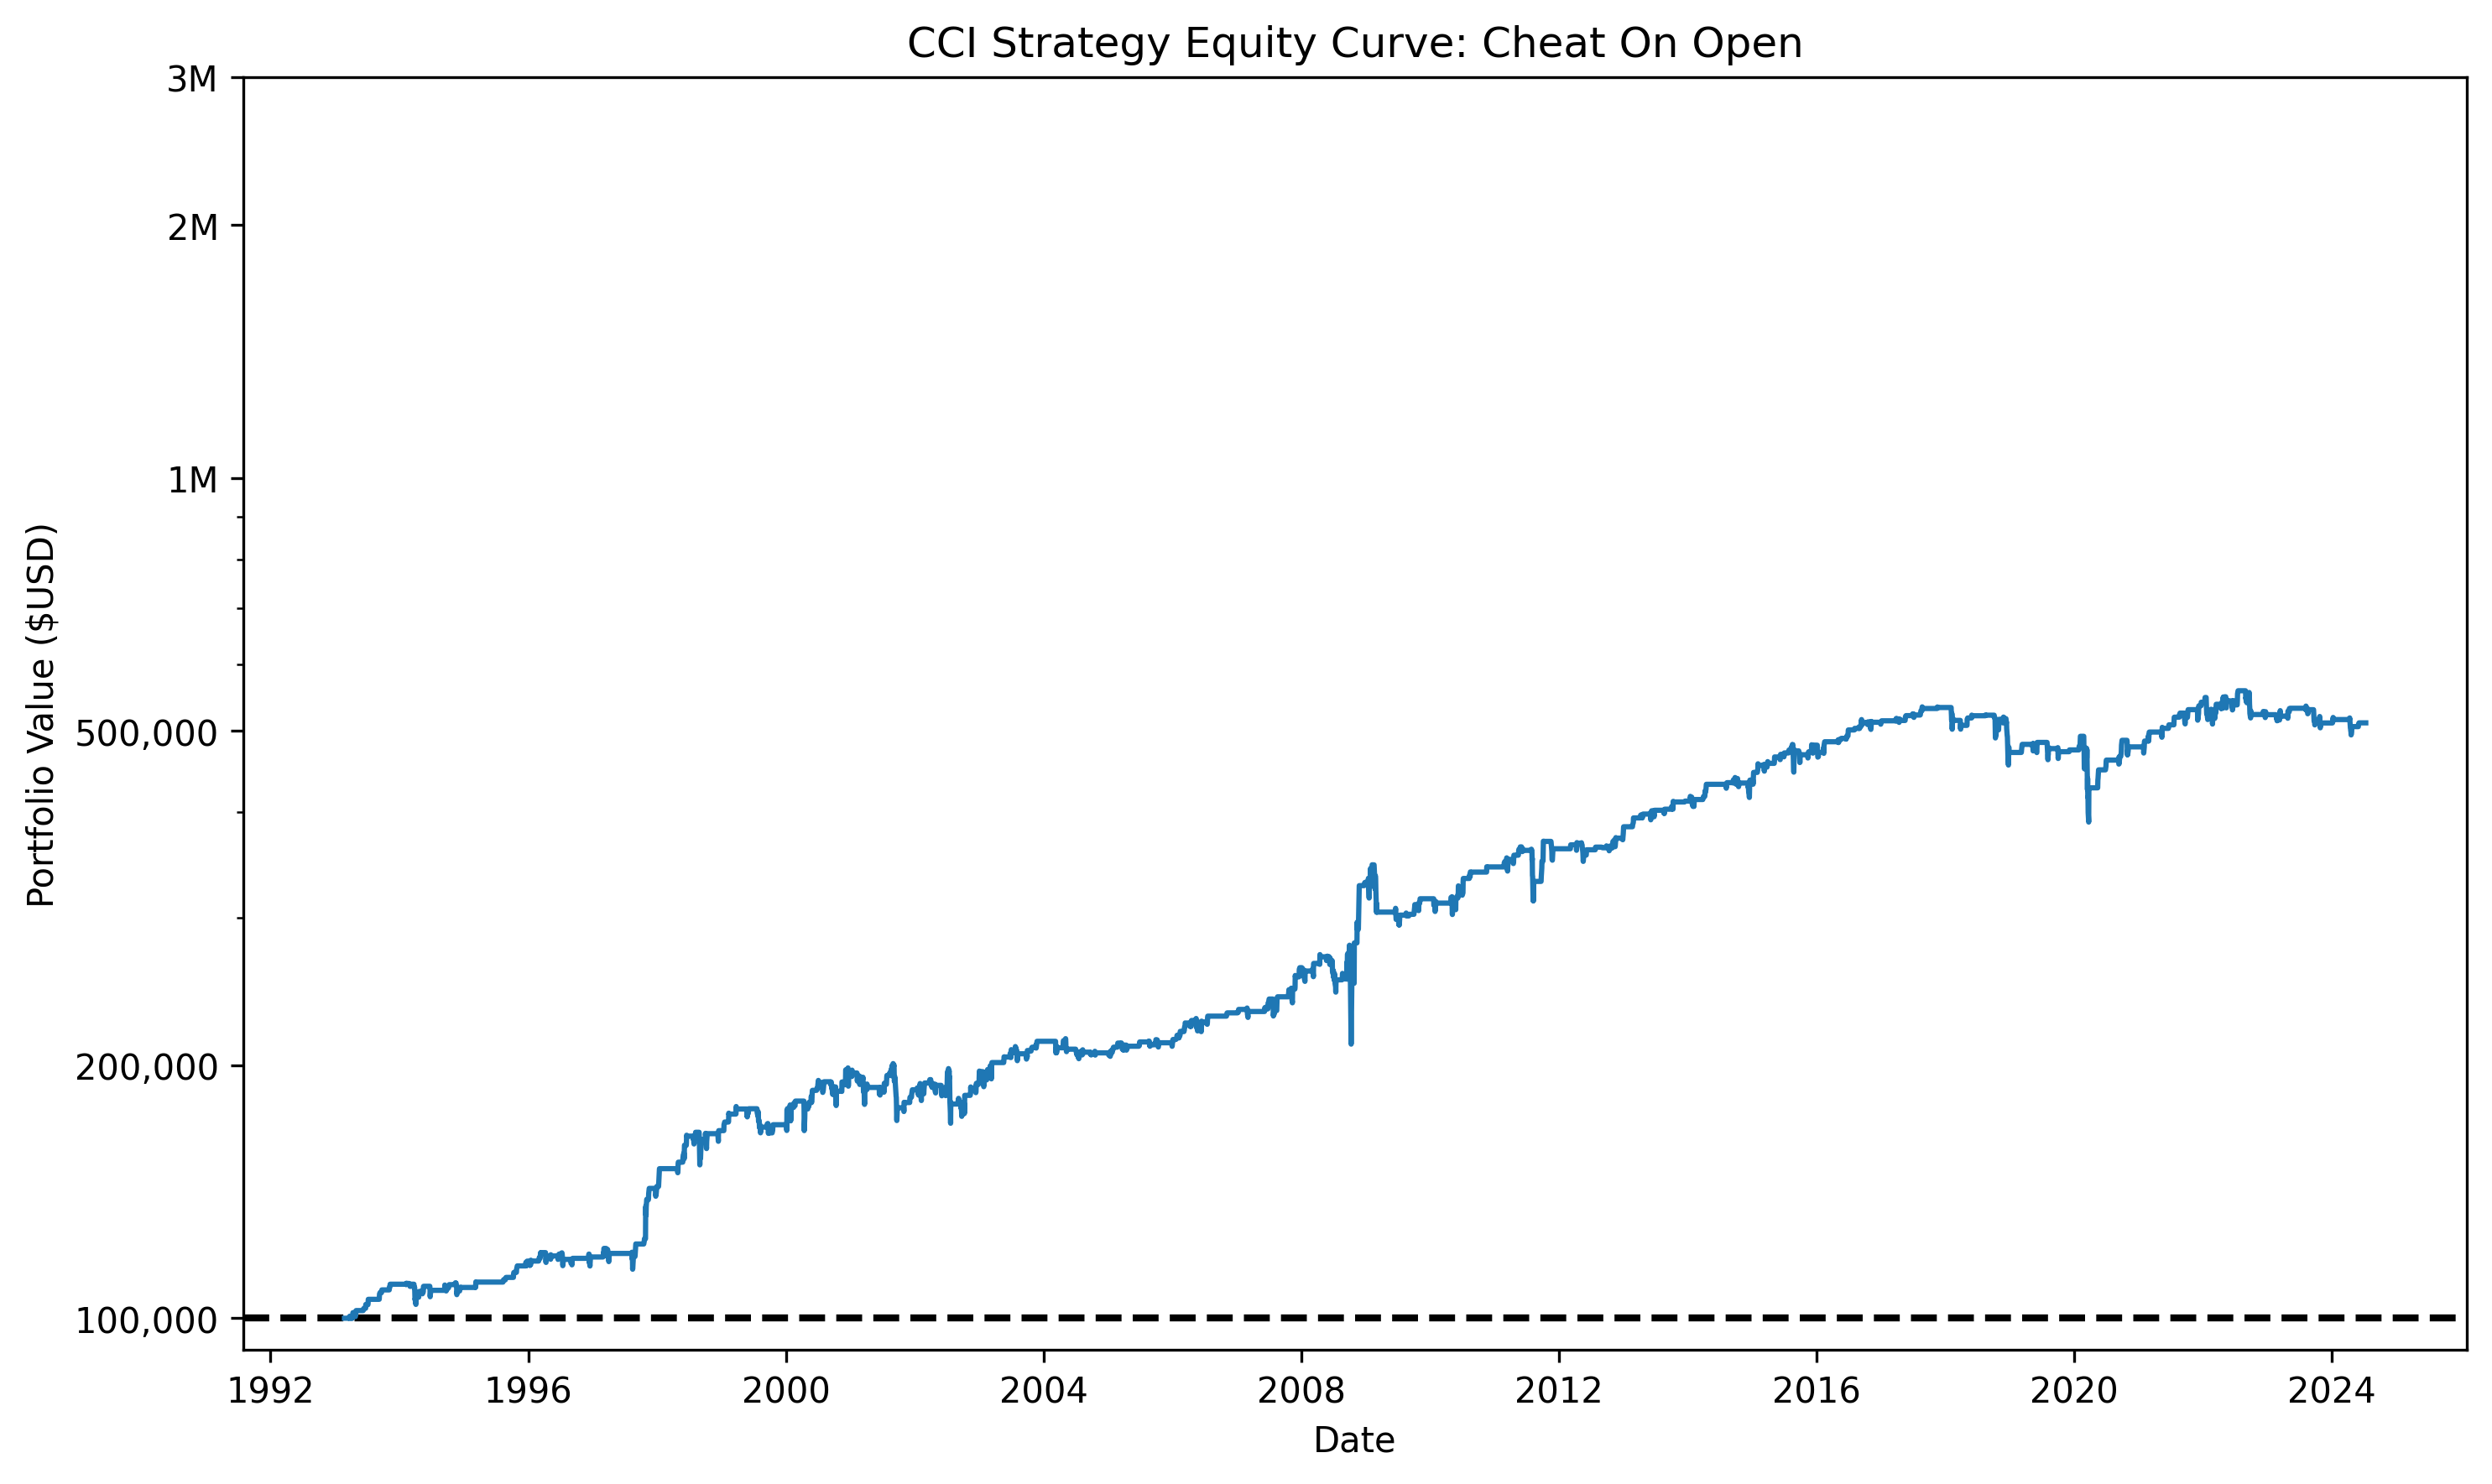

In [10]:
plt.figure(figsize=(10, 6), dpi=300)
plt.axhline(y=100000, color='black', linestyle='--', linewidth=2)

plt.plot(strat[0].dates,strat[0].equity_curve)
plt.title(f"CCI Strategy Equity Curve: Cheat On Open")
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($USD)')

yticks = [100000, 200000, 500000, 1000000, 2000000, 3000000]
ytick_labels = ['100,000', '200,000', '500,000', '1M', '2M', '3M']

# Set custom y-axis ticks and labels
plt.yscale('log')
plt.yticks(ticks=yticks, labels=ytick_labels)

plt.tight_layout()

#### COC: True

In [11]:
# Create a cerebro engine instance
cerebro = bt.Cerebro(cheat_on_open=False)
start_date = datetime(1993, 1, 29)
end_date = datetime(2024, 7, 12)
data = bt.feeds.YahooFinanceCSVData(dataname='../Data/SPY.csv', fromdate=start_date, todate=end_date, adjclose=True, round=False)
cerebro.adddata(data)

# Add the WilliamsR strategy
cerebro.addstrategy(CCIStrategy, period=9, lowerband=-90.0)
cerebro.broker.setcommission(commission=0.0)
cerebro.broker.set_coc(True)

# Set initial capital and broker settings
# This code was assited using Codeium autocomplete
start_cash = 100000.0000
cerebro.broker.setcash(start_cash)
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name="trade_stats")
cerebro.addanalyzer(btanalyzers.DrawDown, _name="drawdown")
cerebro.addanalyzer(btanalyzers.Returns, _name="returns")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, 
                _name='sharpe',
                timeframe=bt.TimeFrame.Days,
                compression=1,
                riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
cerebro.addanalyzer(InMarketAnalyzer, _name="in_market")
cerebro.addanalyzer(CashValueAnalyzer, _name="cash_value")
cerebro.addanalyzer(SortinoRatio, _name='sortino')

# Print starting capital
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run the strategy
strat = cerebro.run()

# Print final capital
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
1993-03-23, BUY EXECUTED, 25.199646
1993-03-26, SELL EXECUTED, 25.410673
1993-04-05, BUY EXECUTED, 24.812773
1993-04-13, SELL EXECUTED, 25.269987
1993-04-23, BUY EXECUTED, 24.724842
1993-04-30, SELL EXECUTED, 24.742434
1993-06-09, BUY EXECUTED, 25.164482
1993-06-14, SELL EXECUTED, 25.375496
1993-06-24, BUY EXECUTED, 25.059465
1993-06-25, SELL EXECUTED, 25.395964
1993-07-07, BUY EXECUTED, 25.059465
1993-07-09, SELL EXECUTED, 25.413662
1993-07-23, BUY EXECUTED, 25.218857
1993-07-27, SELL EXECUTED, 25.484497
1993-09-09, Buy Order Margin
1993-09-21, BUY EXECUTED, 25.910597
1993-09-23, SELL EXECUTED, 26.035334
1993-11-05, BUY EXECUTED, 26.142260
1993-11-09, SELL EXECUTED, 26.302641
1993-11-23, Buy Order Margin
1994-02-08, BUY EXECUTED, 27.092724
1994-02-10, SELL EXECUTED, 27.218327
1994-02-25, BUY EXECUTED, 26.751839
1994-03-07, SELL EXECUTED, 26.805651
1994-03-25, BUY EXECUTED, 26.779819
1994-04-06, SELL EXECUTED, 25.877544
1994-04-19, BUY EXECUTED, 25.5

In [12]:
print(print_strategy_stats(strat[0]))


| Metric                          | Value         |
|---------------------------------|---------------|
| Initial Capital                 | 100000.00     |
| Ending Capital                  | 758756.28      |
| Net Profit                      | 658756.28 |
| Net Profit %                    | 202.65%    |
| Exposure %                      | 16.09%           |
| Net Risk Adjusted Return        | 41.41%      |
| Annual Return %                 | 6.66%   |
| Risk Adjusted Return %          | 41.41%      |
| Transaction Costs               | 0.00                                  |

| All Trades                      |               |
|---------------------------------|---------------|
| Total Number of Trades          | 349            |
| Avg. Profit/Loss                | 1.89                        |
| Avg. Profit/Loss %              | N/A                                   |
| Avg. Bars Held                  | N/A                                   |

| Winners                         |    


| Metric                          | Value         |
|---------------------------------|---------------|
| Initial Capital                 | 100000.00     |
| Ending Capital                  | 758756.28      |
| Net Profit                      | 658756.28 |
| Net Profit %                    | 202.65%    |
| Exposure %                      | 16.09%           |
| Net Risk Adjusted Return        | 41.41%      |
| Annual Return %                 | 6.66%   |
| Risk Adjusted Return %          | 41.41%      |
| Transaction Costs               | 0.00                                  |

| All Trades                      |               |
|---------------------------------|---------------|
| Total Number of Trades          | 349            |
| Avg. Profit/Loss                | 1.89                        |
| Avg. Profit/Loss %              | N/A                                   |
| Avg. Bars Held                  | N/A                                   |

| Winners                         |               |
|---------------------------------|---------------|
| Total Profit                    | 1240546.01         |
| Avg. Profit                     | 4789.75     |
| Avg. Profit %                   | N/A                                   |
| Avg. Bars Held                  | N/A                                   |
| Max. Consecutive Wins           | 14      |
| Largest Win                     | N/A                                   |
| Bars in Largest Win             | N/A                                   |

| Losers                          |               |
|---------------------------------|---------------|
| Total Loss                      | -581789.73        |
| Avg. Loss                       | -6464.33    |
| Avg. Loss %                     | N/A                                   |
| Avg. Bars Held                  | N/A                                   |
| Max. Consecutive Losses         | 5     |
| Largest Loss                    | N/A                                   |
| Bars in Largest Loss            | N/A                                   |

| Additional Metrics              |               |
|---------------------------------|---------------|
| Max. Trade Drawdown             | N/A                                   |
| Max. Trade % Drawdown           |                                       |
| Max. System Drawdown            | 68739.65     |
| Max. System % Drawdown          | 23.75% |
| Recovery Factor                 | N/A                                   |
| CAR/MaxDD                       | N/A                                   |
| RAR/MaxDD                       | N/A                                   |
| Profit Factor                   | 2.1322927168834567                       |
| Payoff Ratio                    | N/A                                   |
| Standard Error                  | N/A                                   |
| Risk-Reward Ratio               | N/A                                   |



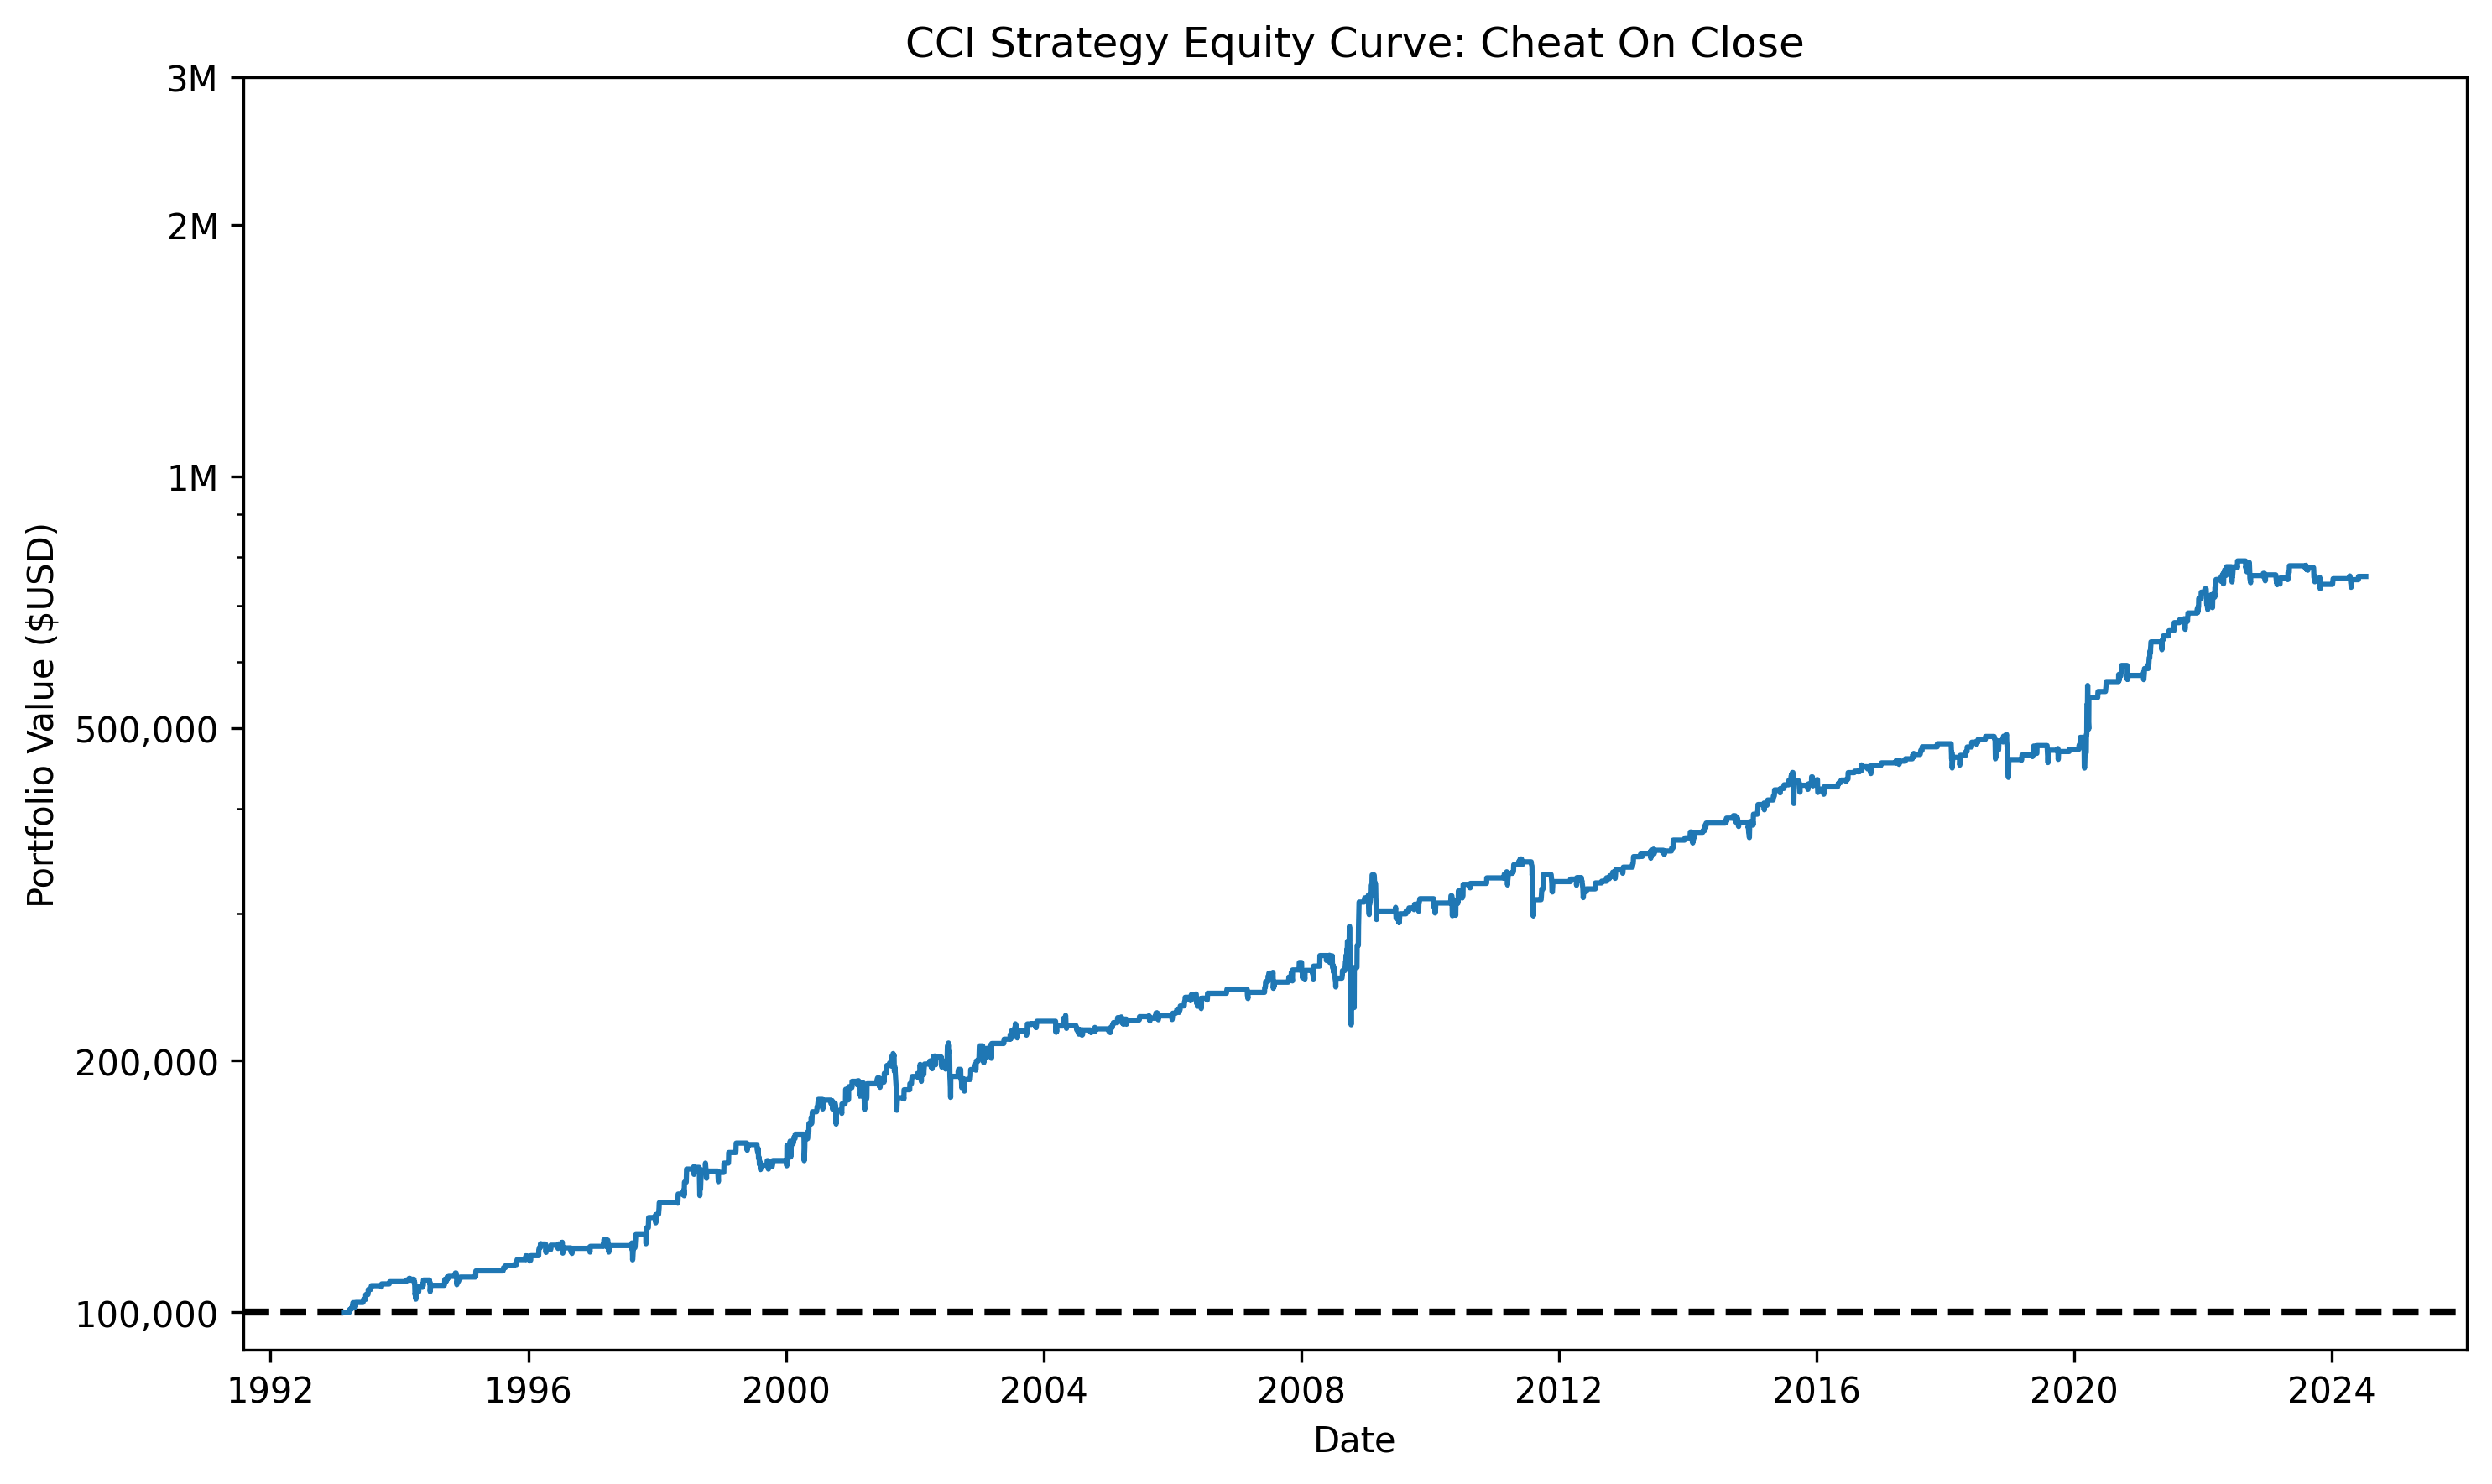

In [13]:
plt.figure(figsize=(10, 6), dpi=300)
plt.axhline(y=100000, color='black', linestyle='--', linewidth=2)

plt.plot(strat[0].dates,strat[0].equity_curve)
plt.title(f"CCI Strategy Equity Curve: Cheat On Close")
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($USD)')

yticks = [100000, 200000, 500000, 1000000, 2000000, 3000000]
ytick_labels = ['100,000', '200,000', '500,000', '1M', '2M', '3M']

# Set custom y-axis ticks and labels
plt.yscale('log')
plt.yticks(ticks=yticks, labels=ytick_labels)

plt.tight_layout()